# Deep NN on MNIST using TensorFlow
#### A high-level tutorial into Deep Learning using MNIST data and TensorFlow library.
by [@kakauandme](https://twitter.com/KaKaUandME) and [@thekoshkina](https://twitter.com/thekoshkina)   
adapted by [@apanisson](https://twitter.com/apanisson)

Accuracy: 0.99


**Prerequisites:** fundamental coding skills, a bit of linear algebra, especially matrix operations and perhaps understanding how images are stored in computer memory. To start with machine learning, we suggest [coursera course](https://www.coursera.org/learn/machine-learning) by Andrew Ng.


Note: 

*Feel free to fork and adjust* CONSTANTS *to tweak network behaviour and explore how it changes algorithm performance and accuracy. Besides **TensorFlow graph** section can also be modified for learning purposes.*

*It is highly recommended printing every variable that isn’t 100% clear for you. Also, [tensorboard](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html) can be used on a local environment for visualisation and debugging.*
## Libraries and settings

In [1]:
# accedere al sito playground.tensorflow.org

    conda install -c conda-forge tensorflow

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 5000    
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 40000

# image number to output
IMAGE_TO_DISPLAY = 10

## Data preparation
To start, we read provided data. The **`train.csv`** file contains 42000 rows and 785 columns. Each row represents an image of a handwritten digit and a label with the value of this digit.

In [4]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST Original", data_home='.') # fetch dataset from internet
X = mnist.data
y = mnist.target
print X.shape

(70000, 784)


Shuffle dataset (which is sorted!)

In [5]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

Every image is a "stretched" array of pixel values.

In this case it's 784 pixels => 28 * 28px 

In [6]:
image_size = X.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


To output one of the images, we reshape this long string of pixels into a 2-dimensional array, which is basically a grayscale image.

The corresponding labels are numbers between 0 and 9, describing which digit a given image is of.

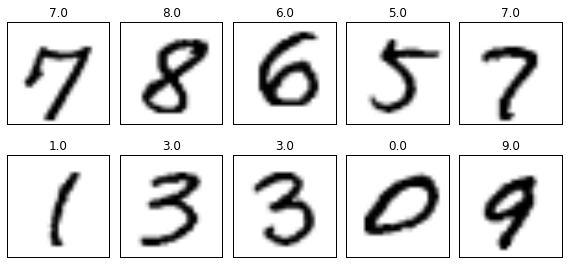

In [7]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in xrange(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

Rescale data into the [0, 1] interval:

In [8]:
X = X / float(X.max())

For most classification problems "one-hot vectors" are used. A one-hot vector is a vector that contains a single element equal to 1 and the rest of the elements equal to 0. In this case, the **`n`**th digit is represented as a zero vector with 1 in the **`n`**th position.

In [9]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense):
    num_classes = np.unique(labels_dense).shape[0]
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.astype(int).ravel()] = 1
    return labels_one_hot

y = dense_to_one_hot(y).astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(y.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY, y[IMAGE_TO_DISPLAY]))

labels(70000,10)
labels[10] => [0 0 0 0 1 0 0 0 0 0]


Lastly we set aside data for validation. It's essential in machine learning to have a separate dataset which doesn't take part in the training and is used to make sure that what we've learned can actually be generalised.


In [10]:
# split data into training & test
X_train = X[VALIDATION_SIZE:]
y_train = y[VALIDATION_SIZE:]

X_test = X[:VALIDATION_SIZE]
y_test = y[:VALIDATION_SIZE]

*Data is ready. The neural network structure is next.*
## TensorFlow graph
TensorFlow does its heavy lifting outside Python. Therefore, instead of running every single operation independently, TensorFlow allows users to build a whole graph of interacting operations and then runs the workflow in a separate process at once.

In [11]:
tf.set_random_seed(1234)

#### Helper functions
For this NN model, a lot of weights and biases are created. Generally, weights should be initialised with a small amount of noise for symmetry breaking, and to prevent 0 gradients. 

Since we are using [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) neurones (ones that contain rectifier function **`f(x)=max(0,x)`**), it is also good practice to initialise them with a slightly positive initial bias to avoid "dead neurones".

In [12]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

For this problem we use zero padded [convolutions](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer) so that the output is the same size as the input. Stride/step in this case is equal to 1.

In general, convolution layer is used to get the features of the data.  In the case of digit recognition - a shape of each digit.  It uses learnable kernels/filters each of which corresponds to one particular shape pattern. The number of the filter can be different for other problems.

In [13]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

[Pooling](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) is plain max pooling over 2x2 blocks.

Pooling is used for downsampling of the data. 2x2 max-pooling splits the image into square 2-pixel blocks and only keeps maximum value for each of those blocks. 

In [14]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

*We'll get back to convolutions and pooling in more detail below.*

The good thing about neural networks that any NN can be used as a layer in a large multilayer NN meaning that output of one can be used as input for another. This sequential approach can create very sophisticated NN with multiple layers. They are also called Deep Neural Networks.

In this case, we use two convolution layers with pooling in between them, then densely connected layer followed by dropout and lastly readout layer.

In [15]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
labels_count = y.shape[1]
y_ = tf.placeholder('float', shape=[None, labels_count])

The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.

After the convolution, pooling reduces the size of the output from 28x28 to 14x14.

In [16]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

The second layer has 64 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 32, 64]. The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to 32 featured that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

Because the image is down-sampled by pooling to 14x14 size second convolutional layer picks up more general characteristics of the images. Filters cover more space of the picture. Therefore, it is adjusted for more generic features while the first layer finds smaller details.

In [17]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

Now that the image size is reduced to 7x7, we add a [fully-connected layer](https://en.wikipedia.org/wiki/Convolutional_neural_network#Fully_Connected_layer) with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the activations/outpus of the previous layer)

In [18]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

To prevent overfitting, we  apply [dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) before the readout layer.

Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the network with probability **`keep_prob`** or dropped with probability **`1 - keep_prob`**. After the training stage is over the nodes are returned to the NN with their original weights.

In [19]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we add a softmax layer, the same one if we use just a  simple [softmax regression](https://en.wikipedia.org/wiki/Softmax_function).

In [20]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

To evaluate network performance we use [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) and to minimise it [ADAM optimiser](http://arxiv.org/pdf/1412.6980v8.pdf) is used. 

ADAM optimiser is a gradient based optimization algorithm, based on adaptive estimates, it's more sophisticated than steepest gradient descent and is well suited for problems with large data or many parameters.

In [21]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
    
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of  an image being one of the digits are highest.

In [22]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

*Finally neural network structure is defined and TensorFlow graph is ready for training.*
## Train, validate and predict
#### Helper functions

Ideally, we should use all data for every step of the training, but that's expensive. So, instead, we use small "batches" of random data. 

This method is called [stochastic training](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). It is cheaper, faster and gives much of the same result.

In [23]:
epochs_completed = 0
index_in_epoch = 0
num_examples = X_train.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global X_train
    global y_train
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = X_train[perm]
        train_labels = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return X_train[start:end], y_train[start:end]

Now when all operations for every variable are defined in TensorFlow graph all computations will be performed outside Python environment.

In [24]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Each step of the loop, we get a "batch" of data points from the training set and feed it to the graph to replace the placeholders.  In this case, it's:  *x, y* and *dropout.*

Also, once in a while, we check training accuracy on an upcoming "batch".

On the local environment, we recommend [saving training progress](https://www.tensorflow.org/versions/master/api_docs/python/state_ops.html#Saver), so it can be recovered for further training, debugging or evaluation.

In [ ]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x: X_train[0:1000], 
                                                  y_: y_train[0:1000], 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={x: X_test[0:1000], 
                                                            y_: y_test[0:1000], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.5f / %.5f for step %d'% \
                  (train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            x_range.append(i)
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.06400 / 0.06700 for step 0
training_accuracy / validation_accuracy => 0.09000 / 0.09900 for step 1
training_accuracy / validation_accuracy => 0.10600 / 0.08800 for step 2
training_accuracy / validation_accuracy => 0.14000 / 0.14900 for step 3
training_accuracy / validation_accuracy => 0.16600 / 0.16500 for step 4
training_accuracy / validation_accuracy => 0.21600 / 0.20100 for step 5
training_accuracy / validation_accuracy => 0.19600 / 0.18300 for step 6
training_accuracy / validation_accuracy => 0.19400 / 0.19900 for step 7
training_accuracy / validation_accuracy => 0.22100 / 0.20600 for step 8
training_accuracy / validation_accuracy => 0.24700 / 0.25200 for step 9
training_accuracy / validation_accuracy => 0.36600 / 0.35700 for step 10
training_accuracy / validation_accuracy => 0.49800 / 0.44500 for step 20
training_accuracy / validation_accuracy => 0.60700 / 0.56000 for step 30
training_accuracy / validation_accuracy => 0.67200 / 0.63100 

After training is done, we check accuracy on data that wasn't used in training.

In [ ]:
# check final accuracy on validation set
validation_accuracy = accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})
print('validation_accuracy => %.4f'%validation_accuracy)

In [ ]:
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, validation_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.01, ymin = 0.0)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.xscale('log')

In [ ]:
sess.close()